## Importing the necessary libraries

In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

pd.set_option('display.max_rows', 500)
import gc

# sklearn preprocessing 
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

import lightgbm as lgb

# File system manangement
import os

#eda
!pip install klib
import klib

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


seed = 2357
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reading Data**

In [ ]:
# Training data
df_train = pd.read_csv("/content/drive/MyDrive/TrainingWiDS2021.csv")
print('Training data shape: ', df_train.shape)
df_train.head()

Training data shape:  (130157, 181)


,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
df_train.drop('Unnamed: 0',axis=1,inplace=True)
print('Training data shape: ', df_train.shape)
df_train.head()

Training data shape:  (130157, 180)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


The training data has 130157 observations and 180 variables including the TARGET (the label we want to predict).

In [ ]:
# Testing data
df_test = pd.read_csv("/content/drive/MyDrive/UnlabeledWiDS2021.csv")
df_test.drop('Unnamed: 0',axis=1,inplace=True)
print('Testing data shape: ', df_test.shape)
df_test.head()

Testing data shape:  (10234, 179)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,82,admit,Med-Surg ICU,0.015278,0,NaN,2.8,110.0,104.01,0,0,1.9,44.0,1.49,NaN,4.0,6.0,0.0,5.0,97.0,38.0,39.9,0,54.0,NaN,NaN,NaN,NaN,31.0,130.0,...,26.0,14.5,14.5,42.8,42.8,NaN,NaN,NaN,NaN,173.0,173.0,4.9,4.9,132.0,132.0,5.6,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,82,admit,Med-Surg ICU,0.000000,0,NaN,NaN,117.0,106.01,0,0,NaN,19.0,0.92,NaN,4.0,6.0,0.0,5.0,73.0,116.0,NaN,0,41.0,NaN,NaN,NaN,NaN,53.0,142.0,...,NaN,NaN,NaN,NaN,NaN,2.2,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
2,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,82,admit,Med-Surg ICU,0.003472,0,NaN,3.2,302.0,109.01,0,0,0.9,24.0,0.77,NaN,4.0,6.0,0.0,5.0,84.0,104.0,34.8,0,117.0,NaN,NaN,NaN,NaN,38.0,137.0,...,32.0,11.8,11.8,36.6,36.6,2.9,2.4,NaN,NaN,243.0,243.0,3.6,3.6,141.0,141.0,6.6,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,82,admit,Med-Surg ICU,0.884028,0,NaN,NaN,113.0,501.05,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,NaN,110.0,NaN,0,61.0,NaN,NaN,NaN,NaN,56.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
4,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,82,admit,Med-Surg ICU,0.013194,0,NaN,3.4,117.0,106.01,0,0,0.4,26.0,1.50,NaN,4.0,6.0,0.0,5.0,99.0,34.0,33.0,0,136.0,NaN,NaN,NaN,NaN,35.0,133.0,...,30.0,10.7,10.7,33.0,33.0,1.1,1.1,NaN,NaN,154.0,154.0,4.0,4.0,133.0,133.0,6.2,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0


The test set is considerably smaller and lacks a TARGET column.

# Exploratory Data Analysis

##  Column Types

In [ ]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Data columns (total 180 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   encounter_id                 130157 non-null  int64  
 1   hospital_id                  130157 non-null  int64  
 2   age                          125169 non-null  float64
 3   bmi                          125667 non-null  float64
 4   elective_surgery             130157 non-null  int64  
 5   ethnicity                    128570 non-null  object 
 6   gender                       130091 non-null  object 
 7   height                       128080 non-null  float64
 8   hospital_admit_source        96959 non-null   object 
 9   icu_admit_source             129917 non-null  object 
 10  icu_id                       130157 non-null  int64  
 11  icu_stay_type                130157 non-null  object 
 12  icu_type                     130157 non-null  object 
 13

In [ ]:
# Number of each type of column
df_train.dtypes.value_counts()

float64    157
int64       17
object       6
dtype: int64

In [ ]:
# Number of unique classes in each object column
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64

# **Missing Values**



In [ ]:
# Function to calculate missing values by column# Funct 

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Greens')

Your selected dataframe has 180 columns.
There are 160 columns that have missing values.


,Missing Values,% of Total Values
h1_bilirubin_min,119861,92.100000
h1_bilirubin_max,119861,92.100000
h1_albumin_max,119005,91.400000
h1_albumin_min,119005,91.400000
h1_lactate_max,118467,91.000000
h1_lactate_min,118467,91.000000
h1_pao2fio2ratio_min,113397,87.100000
h1_pao2fio2ratio_max,113397,87.100000
h1_arterial_ph_max,107849,82.900000
h1_arterial_ph_min,107849,82.900000


In [ ]:
# Missing values for testing data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Greens')

Your selected dataframe has 179 columns.
There are 159 columns that have missing values.


,Missing Values,% of Total Values
h1_lactate_min,9421,92.100000
h1_lactate_max,9421,92.100000
h1_bilirubin_min,9407,91.900000
h1_bilirubin_max,9407,91.900000
h1_albumin_max,9365,91.500000
h1_albumin_min,9365,91.500000
h1_pao2fio2ratio_min,8812,86.100000
h1_pao2fio2ratio_max,8812,86.100000
h1_arterial_ph_min,8401,82.100000
h1_arterial_ph_max,8401,82.100000


Long column names detected (>25 characters). Consider renaming the following columns ['solid_tumor_with_metastasis'].
Shape of cleaned data: (130157, 173)Remaining NAs: 7303527

Changes:
Dropped rows: 0
     of which 0 duplicates. (Rows: [])
Dropped columns: 7
     of which 1 single valued.     Columns: ['readmission_status']
Dropped missing values: 714666
Reduced memory by at least: 94.42 MB (-52.83%)



GridSpec(6, 6)

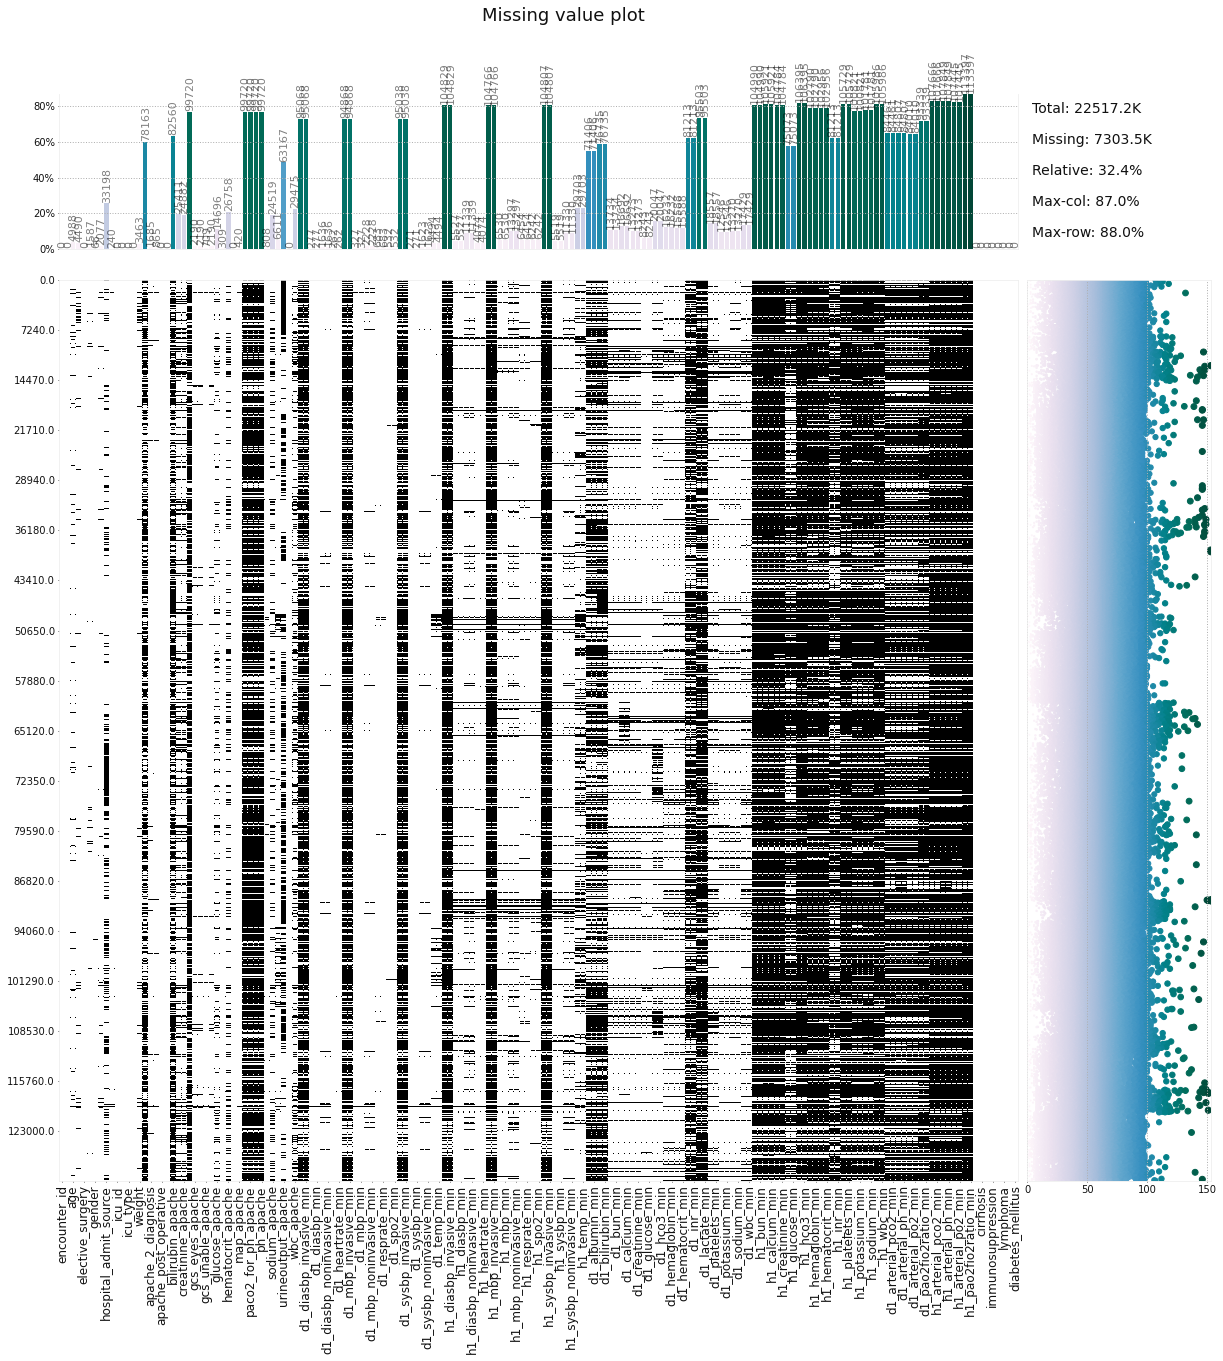

In [ ]:
df_cleaned_train = klib.data_cleaning(df_train)
klib.missingval_plot(df_cleaned_train)

## The Target Column

In [ ]:
df_train['diabetes_mellitus'].value_counts(normalize=True)

0    0.783715
1    0.216285
Name: diabetes_mellitus, dtype: float64

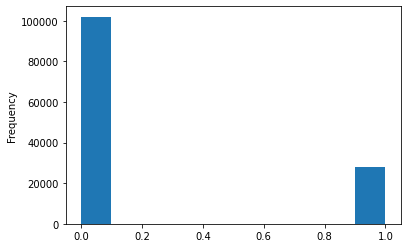

In [ ]:
df_train['diabetes_mellitus'].astype(int).plot.hist();

Text(0, 0.5, 'Number of people Suffering')

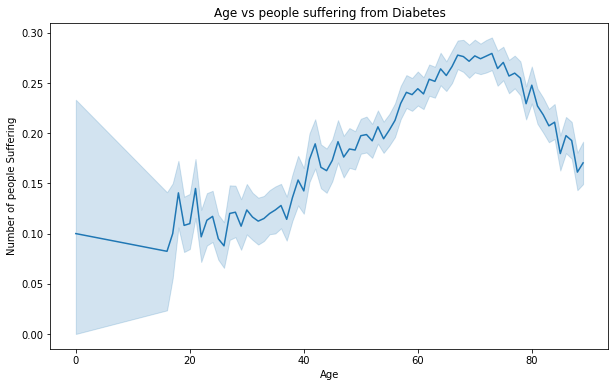

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Age vs people suffering from Diabetes")
sns.lineplot(df_train["age"],df_train["diabetes_mellitus"])
plt.xlabel("Age")
plt.ylabel("Number of people Suffering")

Text(0, 0.5, 'Number of people Suffering')

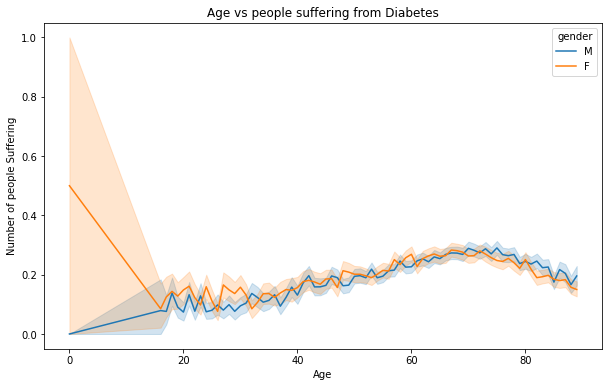

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Age vs people suffering from Diabetes")
sns.lineplot(data=df_train, x="age", y="diabetes_mellitus", hue="gender")
plt.xlabel("Age")
plt.ylabel("Number of people Suffering")

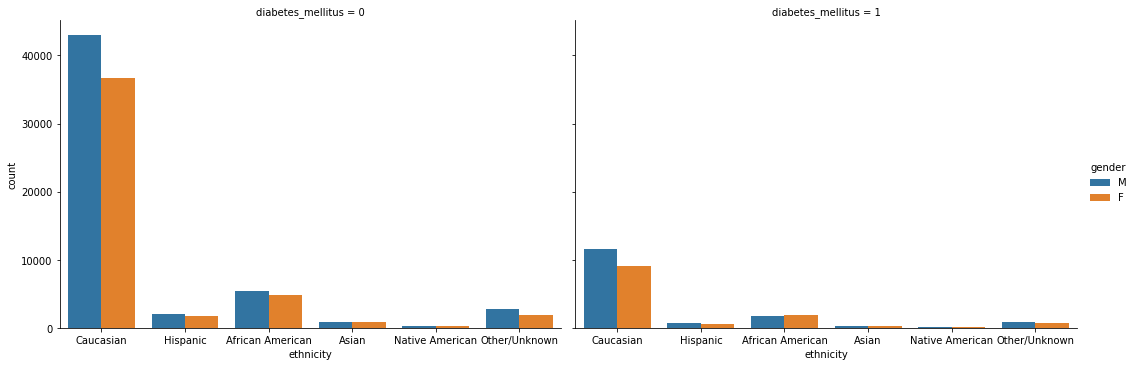

In [ ]:
# Ethnicity vs Diabetes 
g = sns.catplot(x="ethnicity", hue="gender", col="diabetes_mellitus",
                data=df_train, kind="count",
                height=5, aspect=1.5);

## Correlation Plot



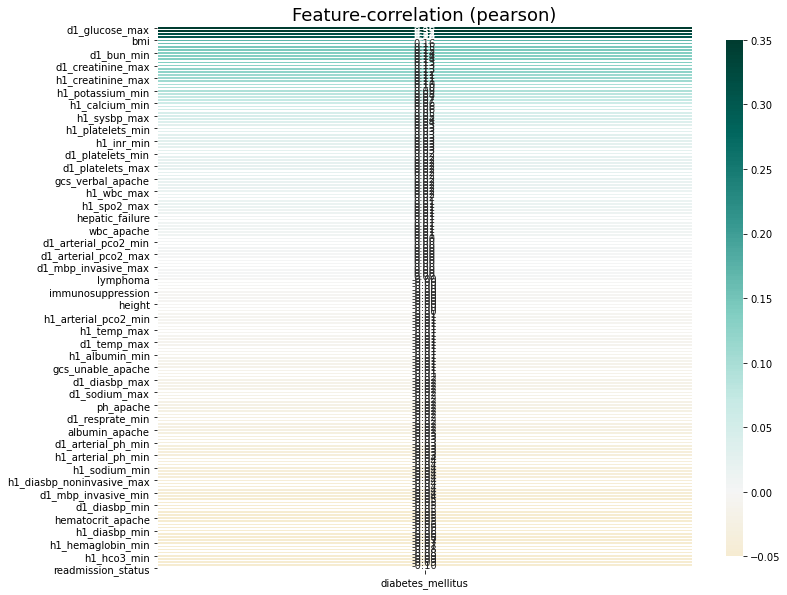

In [ ]:
#Display correlation with a target variable of interest
klib.corr_plot(df_train, target='diabetes_mellitus')

## Preprocessing Data



In [ ]:


train_copy = df_train.copy()
test_copy = df_test.copy()

# flag field to distinguish records from training and testing sets in the combined dataset
train_copy['source'] = 0
test_copy['source'] = 1


all_data = pd.concat([train_copy, test_copy], axis=0, copy=True)
del train_copy
del test_copy
gc.collect()


125

### Dropping unnecessary columns
There were no recurring patient visits, so the encounter_id would not be relevant to our models

In [ ]:
all_data.drop('encounter_id',axis=1,inplace=True)


let's check if there is overlap between the hospitals in the labelled dataset and the hospitals in the unlabelled dataset

In [ ]:
df_train['hospital_id'].isin(df_test['hospital_id']).value_counts()

False    130157
Name: hospital_id, dtype: int64

In [ ]:
# Dropping hospital id also
all_data.drop('hospital_id',axis=1,inplace=True)

### Encoding Categorical Variables



GridSpec(6, 6)

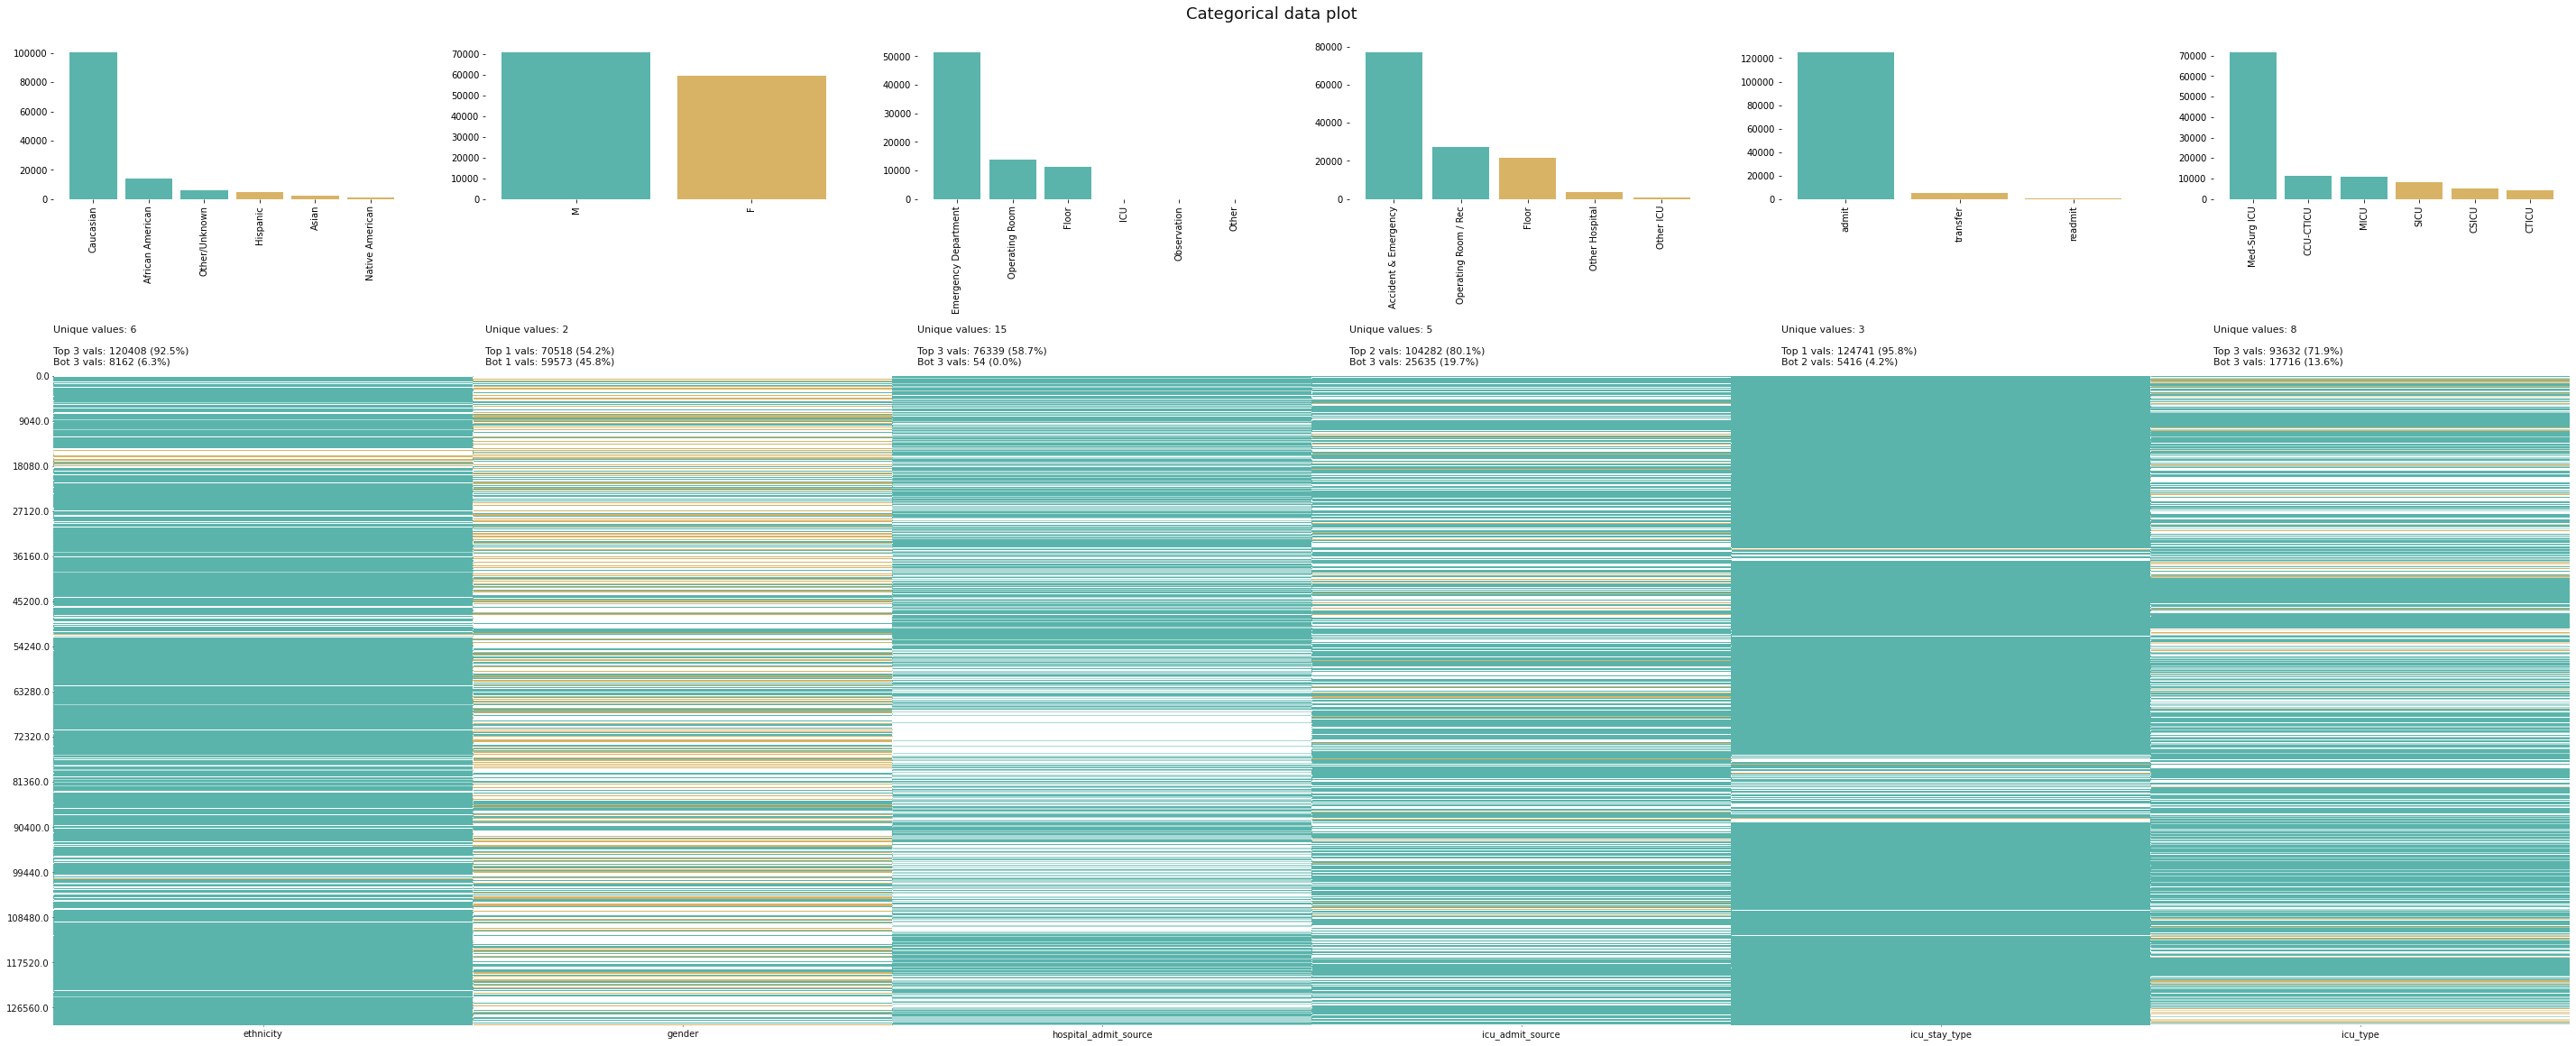

In [ ]:
klib.cat_plot(df_train, figsize=(50,20))

In [ ]:
categorical_columns = all_data.select_dtypes('object').columns
categorical_columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type'],
      dtype='object')

In [ ]:
objList = all_data.select_dtypes(include = "object").columns
print (objList)


# Creating a label encoder object
le = LabelEncoder()
for feat in objList:
    all_data[feat] = le.fit_transform(all_data[feat].astype(str))

print (all_data.info())



Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140391 entries, 0 to 10233
Columns: 179 entries, age to source
dtypes: float64(158), int64(21)
memory usage: 192.8 MB
None


In [ ]:
all_data[categorical_columns].head()

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,2,1,4,1,0,2
1,2,0,4,1,0,5
2,2,0,3,0,0,5
3,2,0,8,2,0,2
4,2,1,15,0,0,5


### Handling missing values

In [ ]:
all_data.fillna(-9999, inplace=True)
all_data.isnull().sum()

age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
height                         0
hospital_admit_source          0
icu_admit_source               0
icu_id                         0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
readmission_status             0
weight                         0
albumin_apache                 0
apache_2_diagnosis             0
apache_3j_diagnosis            0
apache_post_operative          0
arf_apache                     0
bilirubin_apache               0
bun_apache                     0
creatinine_apache              0
fio2_apache                    0
gcs_eyes_apache                0
gcs_motor_apache               0
gcs_unable_apache              0
gcs_verbal_apache              0
glucose_apache                 0
heart_rate_apache              0
hematocrit_apache              0
intubated_

### split the all-data DF into training and testing again

In [ ]:
# split the all-data DF into training and testing again
training = all_data[all_data['source']==0]
testing = all_data[all_data['source']==1]

del all_data
gc.collect()

311

In [ ]:
print(training.shape)
print(testing.shape)

(130157, 179)
(10234, 179)


In [ ]:
testing.drop('diabetes_mellitus',axis=1,inplace=True)
print(testing.shape)

(10234, 178)


# Baseline

### **1. Logistic Regression**

In [ ]:
TARGET = 'diabetes_mellitus'
train_labels = training[TARGET]
train = training.drop(columns = [TARGET,'source'])
features = list(train.columns)
test = testing.drop(columns = ['source'])
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (130157, 177)
Testing data shape:  (10234, 177)


In [ ]:

log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, train_labels)


LogisticRegression(C=0.0001)

In [ ]:

log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [ ]:
log_reg_pred 

array([0.33043761, 0.26749958, 0.32892825, ..., 0.05827944, 0.05959594,
       0.02618623])

In [ ]:
submit = df_test[['encounter_id']]
submit['diabetes_mellitus'] = log_reg_pred
submit.to_csv('logreg_baseline.csv',index=False)
submit.head()

,encounter_id,diabetes_mellitus
0,144740,0.330438
1,141990,0.267500
2,142038,0.328928
3,138628,0.095155
4,141682,0.323641


### **2. Random Forest**

In [ ]:

rf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
rf.fit(train, train_labels)

feature_importance_values = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

predictions = rf.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
submit = df_test[['encounter_id']]
submit['diabetes_mellitus'] = predictions

submit.to_csv('random_forest_baseline_domain.csv', index = False)

# Feature Engineering



In [ ]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
  
    
    return df

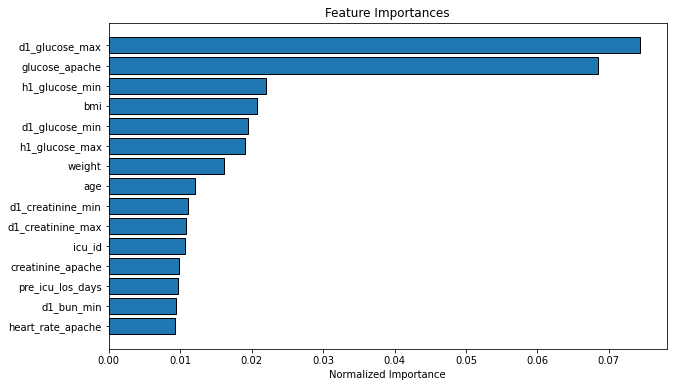

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [ ]:
numerical_columns = train.columns[~train.columns.isin(categorical_columns)]

# Evaluating the model


### Creating a Validation set


In [ ]:
X = train
y = train_labels

train_X, val_X, train_y, val_y = train_test_split( X, y, test_size=0.20,random_state=0)

## **Logistic Regression**

In [ ]:
# Logistic Regression

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions2 = lr.predict_proba(val_X)[:,1]
roc_auc_score(val_y, predictions2)




0.6494764066051497

## **Random Forest**

In [ ]:
# RF

rf.fit(train_X, train_y)
predictions3 = rf.predict_proba(val_X)[:,1]
roc_auc_score(val_y, predictions3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished


0.8290978399203652

# **Light GBM**

In [ ]:
# Light GBM

d_train=lgb.Dataset(train_X, label=train_y)

#Specifying the parameter
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10

#train the model 
clf=lgb.train(params,d_train,100) #train the model on 100 epocs

predictions_lgb = clf.predict(val_X)
roc_auc_score(val_y, predictions_lgb)

0.8449149309317078

# **XGBoost**

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb

model_XGB = XGBClassifier(use_label_encoder=False, eval_metric="auc")
model_XGB.fit(train_X, train_y)
print("XGBClassifier : On validation set, the ROC AUC score is ",roc_auc_score(val_y, model_XGB.predict_proba(val_X)[:,1]))

XGBClassifier : On validation set, the ROC AUC score is  0.8486440311385709


# **Cross Validation**

**XGBoost with Cross Validation**

In [ ]:

scores_xgb = cross_val_score(model_XGB, X, y, cv=10, scoring='roc_auc')
scores_xgb.sort()
print('Mean Absolute Score %2f' %(scores_xgb.mean()))

Mean Absolute Score 0.824544


**Logistic Regression with Cross Validation**

In [ ]:

scores_log = cross_val_score(lr, X, y, cv=10, scoring='roc_auc')
scores_log.sort()
print('Mean Absolute Score %2f' %(scores_log.mean()))

Mean Absolute Score 0.643712


**Random Forest with Cross Validation**

In [ ]:

scores_rf = cross_val_score(rf, X, y, cv=10, scoring='roc_auc')
scores_rf.sort()
print('Mean Absolute Score %2f' %(scores_rf.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]:

Mean Absolute Score 0.822345


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


# **Stratified K-Fold**

**Random Forest with Stratified K-Fold**

In [ ]:
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    #model
    lr = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
    #lr = LogisticRegression(C = 0.0001)
    lr.fit(xtr,ytr)
    score = roc_auc_score(yvl,lr.predict_proba(xvl)[:,1])
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = lr.predict_proba(test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


ROC AUC score: 0.8284436988135645


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


2 of KFold 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


ROC AUC score: 0.8256516071493312


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


3 of KFold 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


ROC AUC score: 0.8228257419617655


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


In [ ]:
#RandomForest 
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s


Confusion matrix
 [[32370  1632]
 [ 6257  3126]]
Cv [0.8284436988135645, 0.8256516071493312, 0.8228257419617655] 
Mean cv Score 0.8256403493082205


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.2s finished


**Light GBM with Stratified K-Fold**

In [ ]:
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    d_train=lgb.Dataset(xtr, label=ytr)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'subsample': 1,
        'colsample_bytree': 0.2,
        'reg_alpha': 3,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'n_estimators': 5404,
        'silent': -1,
        'verbose': -1,
        'max_depth': -1,
        'seed':i + 666,
    }


    #train the model 
    clf=lgb.train(params,d_train,100)

  
    score = roc_auc_score(yvl,clf.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = clf.predict(test)
    pred_test_full +=pred_test
    i+=1

1 of KFold 3
ROC AUC score: 0.8738445874228451
2 of KFold 3
ROC AUC score: 0.871478480554752
3 of KFold 3
ROC AUC score: 0.8697095561762789


In [ ]:
#LGBM
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Cv [0.8738445874228451, 0.871478480554752, 0.8697095561762789] 
Mean cv Score 0.8716775413846253


In [ ]:
submit = df_test[['encounter_id']]
submit['diabetes_mellitus'] = pred_test
submit.to_csv('lgbm_baseline.csv',index=False)
submit.head(25)

,encounter_id,diabetes_mellitus
0,144740,0.046938
1,141990,0.137588
2,142038,0.194493
3,138628,0.062345
4,141682,0.294481
5,139096,0.084173
6,142994,0.614300
7,141954,0.046488
8,135344,0.641694
9,142552,0.795970


**XGBoost with Stratified K-Fold**

In [ ]:
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]

    XGB = XGBClassifier(use_label_encoder=False, eval_metric="auc")
    XGB.fit(xtr, ytr)
    
    score = roc_auc_score(yvl,XGB.predict_proba(xvl)[:,1])
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = XGB.predict_proba(test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 3
ROC AUC score: 0.8494461445475375
2 of KFold 3
ROC AUC score: 0.8486643936069556
3 of KFold 3
ROC AUC score: 0.8460259605194153


In [ ]:
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Cv [0.8494461445475375, 0.8486643936069556, 0.8460259605194153] 
Mean cv Score 0.8480454995579695


## **Reciever Operating Characteristics**

Text(0.5, 0, 'False positive rate')

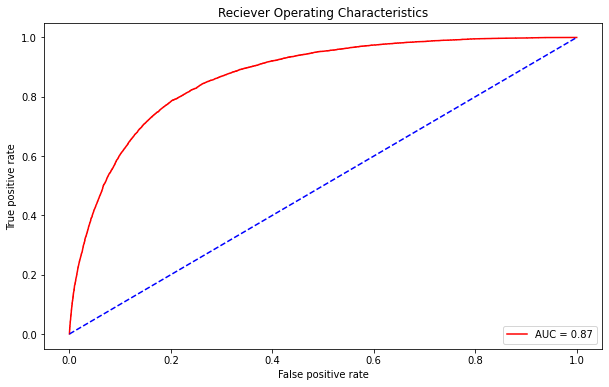

In [ ]:
proba = clf.predict(xvl)
frp,trp, threshold = roc_curve(yvl,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(10,6))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')